In [456]:
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
from pylab import mpl, plt
import pandas as pd
import csv
from sklearn.covariance import LedoitWolf

#
# Exercise 1

# Model 1

In [420]:
raw = pd.read_csv('MidtermData1.csv', index_col=0, parse_dates=True).dropna()
symbols = ['SPX', 'DJI', 'FTSE100', 'EZU', 'GLD']
data = raw[symbols]
data = data.dropna()
data

,SPX,DJI,FTSE100,EZU,GLD
2020-01-31,3225.52,28256.03,9616.84,40.48,149.33
2020-02-07,3327.71,29102.51,9625.26,41.63,147.79
2020-02-14,3380.16,29398.08,9665.93,41.94,149.00
2020-02-21,3337.75,28992.41,9602.14,41.51,154.70
2020-02-28,2954.22,25409.36,8436.36,37.49,148.38
2020-03-06,2972.37,25864.78,8431.69,37.01,157.55
2020-03-13,2711.02,23185.62,6587.42,30.43,143.28
2020-03-20,2304.92,19173.98,6042.61,26.49,140.11
2020-03-27,2541.47,18591.93,6863.63,30.31,152.25


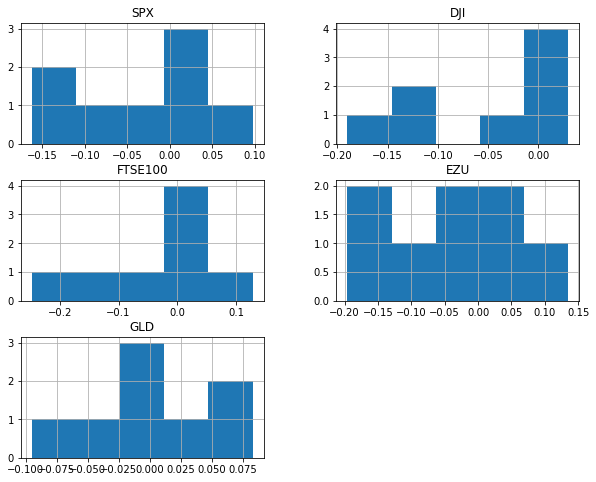

In [421]:
noa = len(symbols)
data = raw[symbols]
rets = np.log(data / data.shift(1))
rets.hist(bins=5, figsize=(10, 8));

## Expected Annual Returns 

In [422]:
ER = rets.mean() * 252
ER

SPX        -7.508073
DJI       -13.185247
FTSE100   -10.624297
EZU        -9.113906
GLD         0.610006
dtype: float64

## Expected Annual Covariance Matrix.

In [423]:
cov = rets.cov() * 252
cov

,SPX,DJI,FTSE100,EZU,GLD
SPX,1.928217,1.543522,1.983477,2.107195,0.930695
DJI,1.543522,1.655363,1.405515,1.537595,0.680630
FTSE100,1.983477,1.405515,3.139459,2.828514,1.508824
EZU,2.107195,1.537595,2.828514,2.761888,1.311895
GLD,0.930695,0.680630,1.508824,1.311895,0.838502


## Annualized portfolio return.

In [427]:
weights = np.random.random(noa)
weights /= np.sum(weights)

In [428]:
weights

array([0.22038173, 0.08395624, 0.26343302, 0.25786727, 0.17436174])

In [429]:
weights.sum()

1.0

In [430]:
np.sum(rets.mean() * weights) * 252

-7.804232658962563

## Annualized portfolio variance

In [431]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

1.9203222405795264

## Annualized portfolio volatility

In [432]:
math.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

1.3857569197299815

## Monte Carlo simulation of portfolio weights

In [433]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

In [434]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)

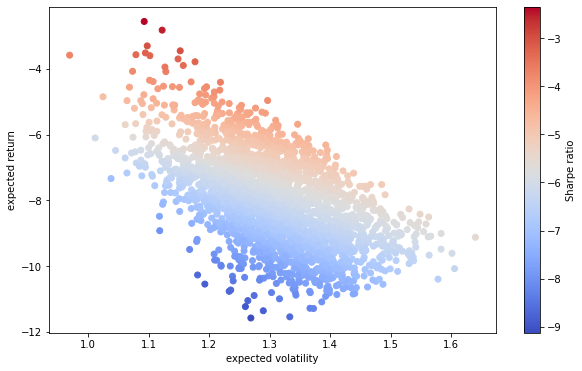

In [435]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

## Optimal Portfolio

In [436]:
import scipy.optimize as sco

In [437]:
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

In [438]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))

In [439]:
eweights = np.array(noa * [1. / noa,])
eweights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [440]:
min_func_sharpe(eweights)

6.144655207256981

In [441]:
%%time
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 20.2 ms, sys: 3.52 ms, total: 23.7 ms
Wall time: 21 ms


In [442]:
opts

     fun: -0.6661658391330573
     jac: array([ 8.93870354e+00,  1.49398687e+01,  1.28011248e+01,  1.09952268e+01,
       -7.45058060e-09])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.00000000e+00, 7.24420524e-14, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00])

In [443]:
opts['x'].round(3)

array([0., 0., 0., 0., 1.])

In [444]:
port_ret(opts['x']).round(3)

0.61

In [445]:
port_vol(opts['x']).round(3)

0.916

## Maximum Sharpe Ratio

In [446]:
port_ret(opts['x']) / port_vol(opts['x'])

0.6661658391330573

##### This sharpe ratio most lilkey would not be accepted!

## Minimum Variance Portfolio

In [447]:
optv = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)

In [448]:
optv

     fun: 0.9036019661583957
     jac: array([1.12451214, 0.90359324, 1.65385282, 1.48666465, 0.90360338])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.00000000e+00, 1.39380502e-01, 2.03692169e-16, 0.00000000e+00,
       8.60619498e-01])

### The optimal portfolio weights.

In [449]:
optv['x'].round(3)

array([0.   , 0.139, 0.   , 0.   , 0.861])

### Volatility of the optimal portfolio.

In [450]:
port_vol(optv['x']).round(3)

0.904

### The optimal portfolio return.

In [451]:
port_ret(optv['x']).round(3)

-1.313

### The maximum Sharpe ratio

In [452]:
port_ret(optv['x']) / port_vol(optv['x'])

-1.452833149477744

## Efficient Frontier

In [453]:
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [454]:
%%time
trets = np.linspace(0.05, 0.2, 50)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 546 ms, sys: 6.39 ms, total: 552 ms
Wall time: 549 ms


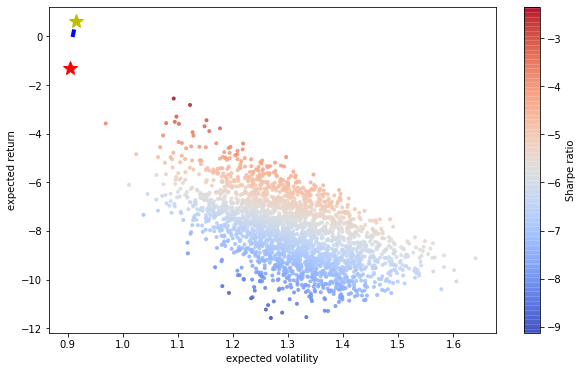

In [455]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#### The Gold Star represents our optimal portfiolio! (aka the portfolio with the maximum sharpe ratio for a given level of volatility). The red star represents the portfolio with the lowest expected volatility.

## The optimal portfolio only comprises of two assets, DJI & GLD. The expected return for this minimum variance portfolio is -1.31%

#


# Model 2

In [322]:
raw = pd.read_csv('MidtermData2.csv', index_col=0, parse_dates=True).dropna()
symbols = ['SPX', 'DJI', 'FTSE100', 'EZU', 'GLD']
data = raw[symbols]
data = data.dropna()
data

,SPX,DJI,FTSE100,EZU,GLD
2015-01-02,2058.20,17737.37,10034.48,36.37,114.08
2015-01-09,2044.81,17511.57,9854.39,35.11,117.26
2015-01-16,2019.42,17672.60,9922.40,36.06,122.52
2015-01-23,2051.82,17164.95,10240.44,36.55,124.23
2015-01-30,1994.99,17824.29,10168.59,36.68,123.45
...,...,...,...,...,...
2019-11-29,3140.98,28015.06,9501.22,40.79,137.86
2019-12-06,3145.91,28135.38,9509.35,40.90,137.62
2019-12-13,3168.80,28455.09,9798.45,41.52,139.05
2019-12-20,3221.22,28645.26,9858.77,41.62,139.52


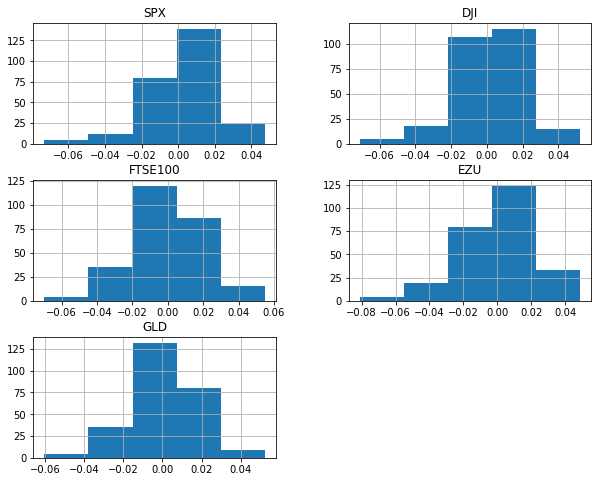

In [323]:
noa = len(symbols)
data = raw[symbols]
rets = np.log(data / data.shift(1))
rets.hist(bins=5, figsize=(10, 8));

## Expected Annual Returns 

In [324]:
ER = rets.mean() * 252
ER

SPX        0.439786
DJI        0.464215
FTSE100   -0.003678
EZU        0.139958
GLD        0.214441
dtype: float64

## Expected Annual Covariance Matrix.


In [325]:
cov = rets.cov() * 252
cov

,SPX,DJI,FTSE100,EZU,GLD
SPX,0.080869,-0.009116,0.064853,0.071078,-0.012158
DJI,-0.009116,0.084472,-0.001579,-0.002349,0.004198
FTSE100,0.064853,-0.001579,0.100930,0.087548,0.002691
EZU,0.071078,-0.002349,0.087548,0.115846,-0.008527
GLD,-0.012158,0.004198,0.002691,-0.008527,0.075724


## Annualized portfolio return.

In [326]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.22494802, 0.09990874, 0.42125092, 0.00904416, 0.24484816])

In [327]:
weights.sum()

1.0

In [328]:
np.sum(rets.mean() * weights) * 252

0.1975298680257619

## Annualized portfolio variance


In [329]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.03947849279576614

## Annualized portfolio volatility


In [330]:
math.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.19869195453204977

## Monte Carlo simulation of portfolio weights


In [331]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)

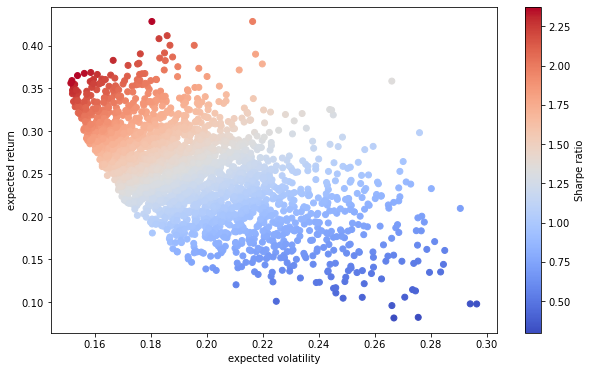

In [332]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

## Optimal Portfolio

In [333]:
import scipy.optimize as sco

In [334]:
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
eweights = np.array(noa * [1. / noa,])
eweights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [335]:
min_func_sharpe(eweights)

-1.360041517715163

In [336]:
%%time
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 50.7 ms, sys: 2.57 ms, total: 53.3 ms
Wall time: 51.3 ms


In [337]:
opts

     fun: -2.5482371734953397
     jac: array([ 2.88760662e-03, -2.89016962e-03,  2.77939734e+00,  1.84271577e+00,
       -5.04165888e-04])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([4.09359675e-01, 3.71347846e-01, 8.86308171e-16, 3.29204437e-16,
       2.19292479e-01])

In [338]:
opts['x'].round(3)

array([0.409, 0.371, 0.   , 0.   , 0.219])

In [339]:
port_ret(opts['x']).round(3)

0.399

In [340]:
port_vol(opts['x']).round(3)

0.157

## Maximum Sharpe Ratio

In [341]:
port_ret(opts['x']) / port_vol(opts['x'])

2.5482371734953397

##### A sharpe ratio between 2-3 is excellent!

## Minimum Variance Portfolio

In [342]:
optv = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv

     fun: 0.15078498412190025
     jac: array([0.15113382, 0.15073505, 0.16199175, 0.15130068, 0.1504496 ])
 message: 'Optimization terminated successfully'
    nfev: 48
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([3.59478771e-01, 2.91070714e-01, 2.16840434e-19, 7.44809517e-03,
       3.42002420e-01])

### The optimal portfolio weights.

In [343]:
optv['x'].round(3)

array([0.359, 0.291, 0.   , 0.007, 0.342])

### Volatility of the optimal portfolio.

In [344]:
port_vol(optv['x']).round(3)

0.151

### The optimal portfolio return.

In [345]:
port_ret(optv['x']).round(3)

0.368

### The maximum Sharpe ratio

In [346]:
port_ret(optv['x']) / port_vol(optv['x'])

2.4378742171104912

## Efficient Frontier

In [347]:
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [348]:
%%time
trets = np.linspace(0.05, 0.2, 50)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 1.13 s, sys: 11.6 ms, total: 1.14 s
Wall time: 1.14 s


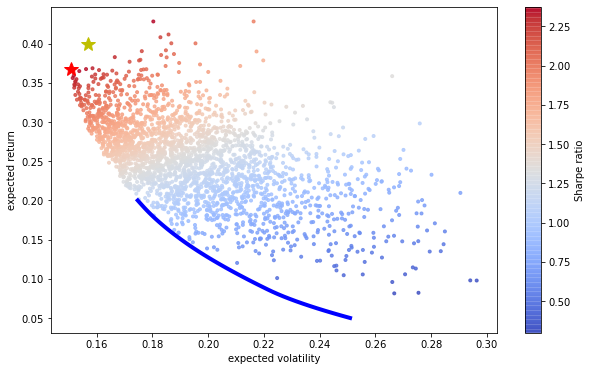

In [349]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#### The Gold Star represents our optimal portfiolio! (aka the portfolio with the maximum sharpe ratio for a given level of volatility). The red star represents the portfolio with the lowest expected volatility.

## The optimal portfolio comprises of a combination of all assets minus one, FTSE100. The expected return for this minimum variance portfolio is 0.37%

#


# Exercise 2

# Model 1

In [701]:
raw = pd.read_csv('MidtermData1.csv', index_col=0, parse_dates=True).dropna()
symbols = ['SPX', 'DJI', 'FTSE100', 'EZU', 'GLD']
data = raw[symbols]
data = data.dropna()
data

,SPX,DJI,FTSE100,EZU,GLD
2020-01-31,3225.52,28256.03,9616.84,40.48,149.33
2020-02-07,3327.71,29102.51,9625.26,41.63,147.79
2020-02-14,3380.16,29398.08,9665.93,41.94,149.00
2020-02-21,3337.75,28992.41,9602.14,41.51,154.70
2020-02-28,2954.22,25409.36,8436.36,37.49,148.38
2020-03-06,2972.37,25864.78,8431.69,37.01,157.55
2020-03-13,2711.02,23185.62,6587.42,30.43,143.28
2020-03-20,2304.92,19173.98,6042.61,26.49,140.11
2020-03-27,2541.47,18591.93,6863.63,30.31,152.25


In [702]:
noa = len(symbols)
data = raw[symbols]
rets = np.log(data / data.shift(1))
real_cov = rets.cov() * 252
real_cov

,SPX,DJI,FTSE100,EZU,GLD
SPX,1.928217,1.543522,1.983477,2.107195,0.930695
DJI,1.543522,1.655363,1.405515,1.537595,0.680630
FTSE100,1.983477,1.405515,3.139459,2.828514,1.508824
EZU,2.107195,1.537595,2.828514,2.761888,1.311895
GLD,0.930695,0.680630,1.508824,1.311895,0.838502


### Annual covariance matrix with the estimated shrinkage


In [704]:
np.random.seed(0)
X = np.random.multivariate_normal(mean=[0, 0, 0, 0, 0], cov=real_cov, size=252)

cov = LedoitWolf().fit(X)
np.set_printoptions(suppress=True)
np.round(cov.covariance_, 6)

array([[1.932148, 1.497503, 1.994028, 2.123837, 0.901219],
       [1.497503, 1.546613, 1.448781, 1.568124, 0.654741],
       [1.994028, 1.448781, 3.092758, 2.819965, 1.441567],
       [2.123837, 1.568124, 2.819965, 2.812469, 1.272387],
       [0.901219, 0.654741, 1.441567, 1.272387, 0.815364]])

## Annualized portfolio return.

In [705]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.06985543, 0.18684614, 0.23755265, 0.1663358 , 0.33940998])

In [706]:
weights.sum()

1.0

In [707]:
np.sum(rets.mean() * weights) * 252

-6.820848580437946

## Annualized portfolio variance


In [708]:
np.dot(weights.T, np.dot(cov.covariance_, weights))

1.51516467785112

## Annualized portfolio volatility


In [709]:
math.sqrt(np.dot(weights.T, np.dot(cov.covariance_, weights)))

1.2309202564955701

## Monte Carlo simulation of portfolio weights


In [710]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov.covariance_, weights)))
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)

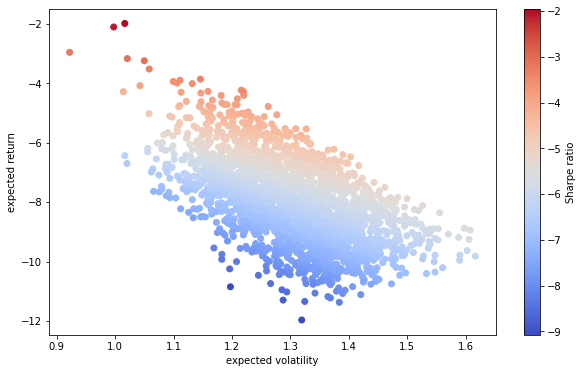

In [711]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

## Optimal Portfolio

In [712]:
import scipy.optimize as sco

In [713]:
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))

eweights = np.array(noa * [1. / noa,])
eweights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [714]:
min_func_sharpe(eweights)

6.1708269847593336

In [715]:
%%time
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 14.5 ms, sys: 2.73 ms, total: 17.2 ms
Wall time: 15.3 ms


In [716]:
opts

     fun: -0.6755517732758048
     jac: array([ 9.06150139, 15.1444751 , 12.96025765, 11.14740401, -0.        ])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0., 0., 0., 0., 1.])

In [717]:
opts['x'].round(3)

array([0., 0., 0., 0., 1.])

In [718]:
port_ret(opts['x']).round(3)

0.61

In [719]:
port_vol(opts['x']).round(3)

0.903

## Maximum Sharpe Ratio

In [720]:
port_ret(opts['x']) / port_vol(opts['x'])

0.6755517732758048

##### This sharpe ratio would most likley not be accepted!

## Minimum Variance Portfolio

In [721]:
optv = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv

     fun: 0.8892980976453733
     jac: array([1.1157278 , 0.88929124, 1.62225456, 1.4815257 , 0.88929933])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.      , 0.152605, 0.      , 0.      , 0.847395])

### The optimal portfolio weights.

In [722]:
optv['x'].round(3)

array([0.   , 0.153, 0.   , 0.   , 0.847])

### Volatility of the optimal portfolio.

In [723]:
port_vol(optv['x']).round(3)

0.889

### The optimal portfolio return.

In [724]:
port_ret(optv['x']).round(3)

-1.495

### The maximum Sharpe ratio

In [725]:
port_ret(optv['x']) / port_vol(optv['x'])

-1.681346432479711

In [726]:
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [727]:
%%time
trets = np.linspace(0.05, 0.2, 50)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 400 ms, sys: 4.81 ms, total: 405 ms
Wall time: 403 ms


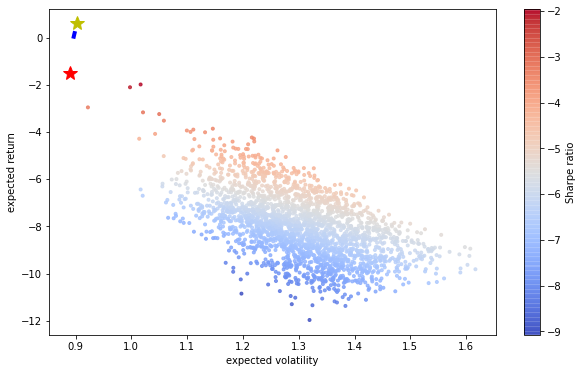

In [728]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#### The Gold Star represents our optimal portfiolio! (aka the portfolio with the maximum sharpe ratio for a given level of volatility). The red star represents the portfolio with the lowest expected volatility.

## The optimal portfolio still only comprises of the two assets DJI & GLD. The expected return for this minimum variance portfolio is -1.31%. Using the new annual covariance matrix with the estimated shrinkage actually negatively effected my portfolio. The weighting of the assets changed slightly and the expected return fell by alomost 0.20%.

#

# Model 2

In [729]:
raw = pd.read_csv('MidtermData2.csv', index_col=0, parse_dates=True).dropna()
symbols = ['SPX', 'DJI', 'FTSE100', 'EZU', 'GLD']
data = raw[symbols]
data = data.dropna()
data

,SPX,DJI,FTSE100,EZU,GLD
2015-01-02,2058.20,17737.37,10034.48,36.37,114.08
2015-01-09,2044.81,17511.57,9854.39,35.11,117.26
2015-01-16,2019.42,17672.60,9922.40,36.06,122.52
2015-01-23,2051.82,17164.95,10240.44,36.55,124.23
2015-01-30,1994.99,17824.29,10168.59,36.68,123.45
...,...,...,...,...,...
2019-11-29,3140.98,28015.06,9501.22,40.79,137.86
2019-12-06,3145.91,28135.38,9509.35,40.90,137.62
2019-12-13,3168.80,28455.09,9798.45,41.52,139.05
2019-12-20,3221.22,28645.26,9858.77,41.62,139.52


In [730]:
noa = len(symbols)
data = raw[symbols]
rets = np.log(data / data.shift(1))
real_cov = rets.cov() * 252
real_cov

,SPX,DJI,FTSE100,EZU,GLD
SPX,0.080869,-0.009116,0.064853,0.071078,-0.012158
DJI,-0.009116,0.084472,-0.001579,-0.002349,0.004198
FTSE100,0.064853,-0.001579,0.100930,0.087548,0.002691
EZU,0.071078,-0.002349,0.087548,0.115846,-0.008527
GLD,-0.012158,0.004198,0.002691,-0.008527,0.075724


### Annual covariance matrix with the estimated shrinkage

In [731]:
np.random.seed(0)
X = np.random.multivariate_normal(mean=[0, 0, 0, 0, 0], cov=real_cov, size=252)

cov = LedoitWolf().fit(X)
np.set_printoptions(suppress=True)
np.round(cov.covariance_, 6)

array([[ 0.077714, -0.00965 ,  0.062013,  0.066125, -0.008822],
       [-0.00965 ,  0.068537, -0.005624, -0.003636,  0.005401],
       [ 0.062013, -0.005624,  0.1035  ,  0.088854,  0.004217],
       [ 0.066125, -0.003636,  0.088854,  0.117314, -0.003718],
       [-0.008822,  0.005401,  0.004217, -0.003718,  0.072577]])

## Annualized portfolio return.

In [732]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.06985543, 0.18684614, 0.23755265, 0.1663358 , 0.33940998])

In [733]:
weights.sum()

1.0

In [734]:
np.sum(rets.mean() * weights) * 252

0.21264780325415153

## Annualized portfolio variance


In [735]:
np.dot(weights.T, np.dot(cov.covariance_, weights))

0.03038560618866134

## Annualized portfolio volatility

In [736]:
math.sqrt(np.dot(weights.T, np.dot(cov.covariance_, weights)))

0.17431467576960163

## Monte Carlo simulation of portfolio weights


In [737]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov.covariance_, weights)))

prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)

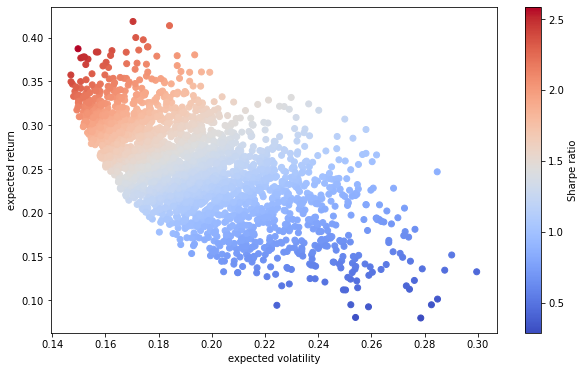

In [738]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

## Optimal Portfolio

In [739]:
import scipy.optimize as sco

In [740]:
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))

eweights = np.array(noa * [1. / noa,])
eweights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [741]:
min_func_sharpe(eweights)

-1.3772674129339935

In [742]:
%%time
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 39.6 ms, sys: 2.59 ms, total: 42.2 ms
Wall time: 40.5 ms


In [743]:
opts

     fun: -2.6899383244058908
     jac: array([ 0.00059807, -0.00001445,  2.67576545,  1.84795839, -0.00125086])
 message: 'Optimization terminated successfully'
    nfev: 50
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.39323775, 0.42367657, 0.        , 0.        , 0.18308568])

In [744]:
opts['x'].round(3)

array([0.393, 0.424, 0.   , 0.   , 0.183])

In [745]:
port_ret(opts['x']).round(3)

0.409

In [746]:
port_vol(opts['x']).round(3)

0.152

## Maximum Sharpe Ratio

In [747]:
port_ret(opts['x']) / port_vol(opts['x'])

2.6899383244058908

##### A sharpe ratio between 2-3 is excellent!

## Minimum Variance Portfolio

In [748]:
optv = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv

     fun: 0.14608257745697653
     jac: array([0.14645162, 0.14591376, 0.14730814, 0.14590226, 0.14585802])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.34586519, 0.33544994, 0.        , 0.00699792, 0.31168695])

### The optimal portfolio weights.

In [749]:
optv['x'].round(3)

array([0.346, 0.335, 0.   , 0.007, 0.312])

### Volatility of the optimal portfolio.

In [750]:
port_vol(optv['x']).round(3)

0.146

### The optimal portfolio return.

In [751]:
port_ret(optv['x']).round(3)

0.376

### The maximum Sharpe ratio

In [752]:
port_ret(optv['x']) / port_vol(optv['x'])

2.5714591482286093

## Efficient Frontier


In [753]:
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [754]:
%%time
trets = np.linspace(0.05, 0.2, 50)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 749 ms, sys: 6.37 ms, total: 755 ms
Wall time: 753 ms


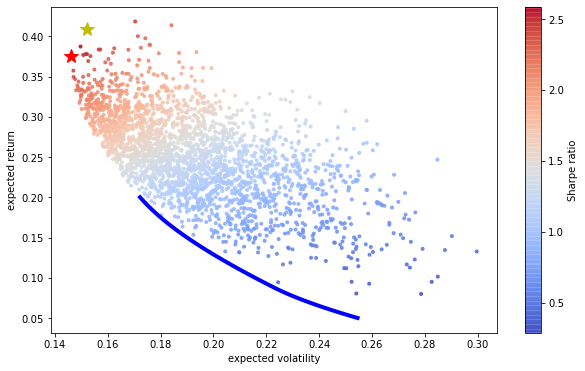

In [755]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#### The Gold Star represents our optimal portfiolio! (aka the portfolio with the maximum sharpe ratio for a given level of volatility). The red star represents the portfolio with the lowest expected volatility.

## The optimal portfolio comprises of a combination of all assets minus one, FTSE100. The expected return for this minimum variance portfolio is 0.38%. Using the new annual covariance matrix with the estimated shrinkage changed up the weighting of the assets and improved the return by 0.008% or almost 1 basis point. 